# MLS Case Study - Recommendation Systems Part 2

---------------
## Context
---------------

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to the users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. For this case study, you can find the dataset [here](https://www.kaggle.com/rounakbanik/the-movies-dataset)

-----------------
## Objective
-----------------

By using the above dataset, we will build two different types recommendation systems - 
- **Clustering based recommendation system**
- **Content based collaborative filtering**

-----------------
## Dataset
-----------------

We will use three datasets for this case study.
- **ratings** dataset that contains the following attributes: 
    - userId
    - movieId
    - rating
    - timestamp

- **movies** dataset that contains the following attributes:
    - movieId
    - title
    - genres
 
- **tags** dataset that contains the following attributes:
    - userId
    - movieId
    - tag: Brief comments about the movie
    - timestamp

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

### Loading data

In [2]:
#Loading the movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies.shape

(9742, 3)

In [4]:
#Loading the ratings dataset
ratings = pd.read_csv('ratings.csv')

In [5]:
ratings.shape

(100004, 4)

Let's **merge both the datasets** to get the title and rating of each movie in a single dataframe

In [6]:
#Merging datasets on movieId 
ratings_with_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId', how='inner')
ratings_with_title.head()

,userId,movieId,rating,timestamp,title
0,1,31,2.5,1260759144,Dangerous Minds (1995)
1,7,31,3.0,851868750,Dangerous Minds (1995)
2,31,31,4.0,1273541953,Dangerous Minds (1995)
3,32,31,4.0,834828440,Dangerous Minds (1995)
4,36,31,3.0,847057202,Dangerous Minds (1995)


Let's check the **info** of the data 

In [7]:
ratings_with_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97243 entries, 0 to 97242
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     97243 non-null  int64  
 1   movieId    97243 non-null  int64  
 2   rating     97243 non-null  float64
 3   timestamp  97243 non-null  int64  
 4   title      97243 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 4.5+ MB


- There are **97,243 observations** and **5 columns** in the data. 
- Notice that the **number of observations has reduced** from ratings data which implies there might be some movies in ratings data which are not in movies data and vice-versa.
- All the columns are of **numeric data type** except the **title column** which is of **object data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [8]:
#Dropping timestamp column
rating = ratings_with_title.drop(['timestamp'], axis=1)

### Exploring the dataset

Let's explore the dataset and answer some basic data-related questions 

#### Q1. How many unique users are present in the above dataset?

In [9]:
ratings_with_title['userId'].nunique()

671

- There are **671 users** in the dataset

#### Q2. What is the total number of unique movies?

In [10]:
ratings_with_title['title'].nunique()

7062

- There are **7062 movies** in the dataset

Now, let's create the **interaction matrix** for these 671 users and 7062 movies in the dataset

In [11]:
interactions_matrix = pd.pivot_table(ratings_with_title, index='userId', columns= 'title', values='rating')
interactions_matrix.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),...,Zoom (2006),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As per the number of unique users and movies, there is a **possibility of 671 * 7062 = 47,38,602 ratings** in the dataset. But **we only have 97,243 ratings**, that is the reason that we are getting a **sparse** user movie interactions matrix above with the majority of the values being **NaN**. We can build a recommendation system to recommend movies to users which they have not interacted with.

To create a **dense** version of the above matrix, let's sort by the most rated movies, and the users who have rated the most number of movies.

In [12]:
def find_most_rated_movies(interactions_matrix, num_movies):
    
    #Appending the count of ratings for each movie as a row in the interaction matrix
    user_movie_ratings = interactions_matrix.append(interactions_matrix.count(), ignore_index=True)
    
    #Sorting the values in the interaction matrix on the basis of the appended row
    user_movie_ratings_sorted = user_movie_ratings.sort_values(user_movie_ratings.shape[0]-1, axis=1, ascending=False)
    
    #Dropping the appended row from the sorted interaction matrix
    user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index, inplace=True)
    
    #Selecting top movies with the most number of ratings
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :num_movies]
                                                    
    return most_rated_movies

In [13]:
#Finding 30 most rated movies
most_rated_movies = find_most_rated_movies(interactions_matrix, 30)
most_rated_movies

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Fight Club (1999),Dances with Wolves (1990),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)","Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,5.0,4.0,4.0,3.0,NaN,NaN,5.0,NaN,NaN
2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,...,NaN,3.0,NaN,NaN,5.0,5.0,NaN,NaN,3.0,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,2.5,NaN,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,4.0,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
667,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,5.0,5.0,NaN,NaN,4.0,4.0,5.0,NaN,...,NaN,1.0,5.0,5.0,NaN,NaN,NaN,3.0,NaN,3.0


In [14]:
def find_most_interacted_users(most_rated_movies, num_users):
    
    #Finding how many of the top 30 movies have been rated by the user 
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    
    #Sorting the dataframe by the new 'counts' columns
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    
    #Selecting top users with the most number of interactions
    most_rated_movies_users_selected = most_rated_movies_users.iloc[:num_users, :]
    
    #Dropping the 'counts' column
    most_rated_movies_users_selected.drop(['counts'], axis=1, inplace=True)
    
    return most_rated_movies_users_selected

In [15]:
#Finding top 18 users with the most number of interactions
most_rated_movies_users_selected = find_most_interacted_users(most_rated_movies, 18)
most_rated_movies_users_selected

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Fight Club (1999),Dances with Wolves (1990),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)","Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,4.0,5.0,4.0,5.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,4.0,5.0,4.0,5.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,5.0,3.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,5.0,4.5,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,5.0,4.5,4.5,5.0,5.0,4.5,5.0,5.0,4.0,5.0
22,4.5,4.5,5.0,4.5,4.5,3.5,4.0,3.0,3.5,3.5,...,3.5,2.5,4.5,4.0,NaN,5.0,4.0,3.5,4.0,4.0
460,4.0,4.5,5.0,5.0,4.5,5.0,4.5,3.5,4.0,5.0,...,5.0,4.0,5.0,4.0,1.5,5.0,4.5,3.0,2.5,NaN
267,5.0,5.0,3.5,5.0,5.0,4.5,4.5,5.0,5.0,5.0,...,4.5,NaN,4.0,3.5,5.0,4.5,5.0,4.5,4.0,3.0
561,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,4.0,5.0,...,4.5,4.0,4.5,5.0,4.5,4.0,5.0,4.5,4.0,4.0
354,5.0,4.5,5.0,4.5,5.0,3.5,5.0,3.0,4.0,4.0,...,5.0,4.0,5.0,3.5,4.0,5.0,4.5,3.0,3.5,4.0


Let's try to **visualize** the above matrix using a heatmap

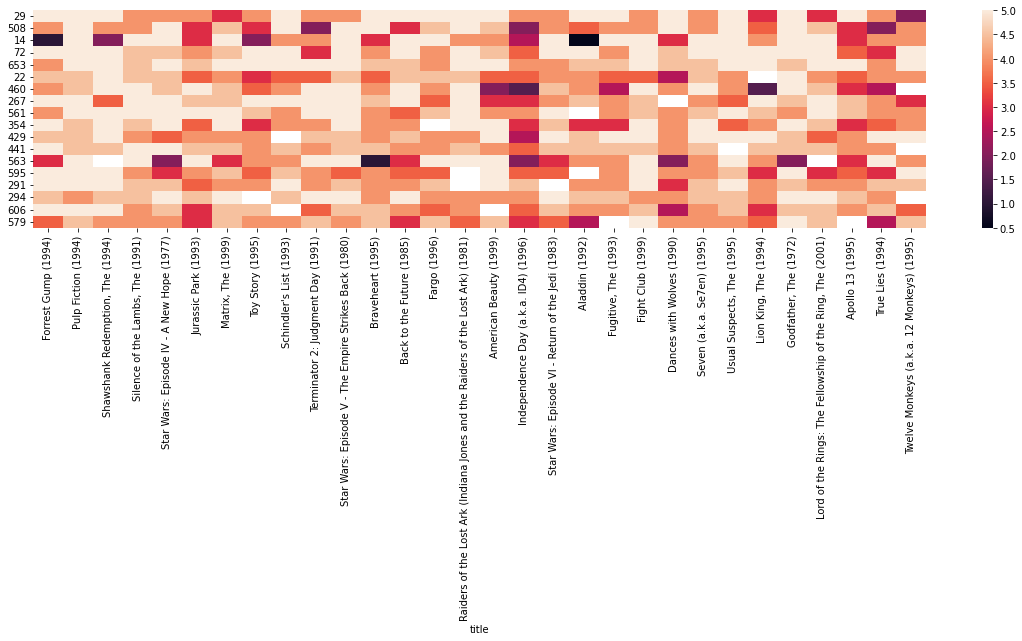

In [16]:
figure = plt.figure(figsize=(20, 4))
sns.heatmap(most_rated_movies_users_selected);

- In the above heatmap, you can see that some **cells are white i.e. the respective user did not rate that movie**. Those are represented by **NaN** in the interactions matrix. 
- Here, we **only used 30 movies**, but if we use all the movies i.e. **9719** then the number of missing ratings will also increase and it will make the interactions matrix a **very sparse matrix**. 

Clustering for a matrix with a lot of missing values is a challenging task. So below we will limit our interactions matrix by only using **1000 most rated movies**.

In [17]:
most_rated_movies_1k = find_most_rated_movies(interactions_matrix, 1000)
most_rated_movies_1k

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Ran (1985),Sliding Doors (1998),Hackers (1995),Halloween (1978),The Hunger Games: Catching Fire (2013),Christmas Vacation (National Lampoon's Christmas Vacation) (1989),Star Trek V: The Final Frontier (1989),"Island of Dr. Moreau, The (1996)",It Could Happen to You (1994),Ocean's Thirteen (2007)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,4.0,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,5.0,5.0,NaN,NaN,4.0,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There are still a lot of **missing values in the data**. We need to **replace them with 0** otherwise, we cannot build the clustering-based model.
- Also, we can see that the **matrix is still sparse**. We can **save it in a compressed format** for sparse matrices to reduce the size of the matrix and consequently **reducing the computation time**.

In [18]:
#Filling missing values and storing the matrix as a sparse matrix
sparse_ratings = csr_matrix(most_rated_movies_1k.fillna(value=0))
sparse_ratings

<671x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 62397 stored elements in Compressed Sparse Row format>

### Cluster Based Recommendation System

In clustering-based recommendation systems, we explore the similarities and differences in people's tastes in movies based on how they rate different movies. We cluster similar users together and recommend movies to a user based on ratings from other users in the same cluster.

First, let's choose the optimal number of clusters i.e. K for K-means clustering

#### Choosing optimal K

We will try different values of k and calculate the **sum of squared errors (SSE) for each k**, then we will use the **elbow plot** to choose the optimal value of k

In [19]:
sse = [] #Empty list to store the sum of squared errors for each value of k

for k in range(2, 50, 5):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(sparse_ratings)
    sse.append(kmeans.inertia_)

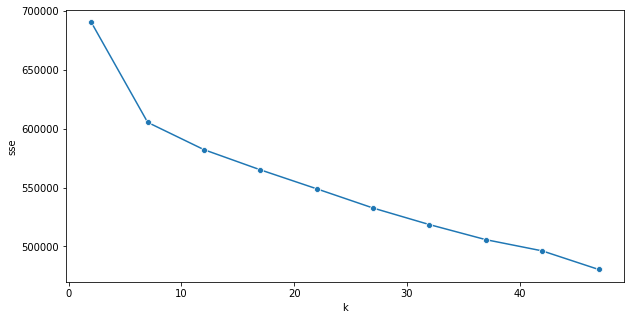

In [20]:
#Plotting elbow plot

error_data = pd.DataFrame({'k':range(2, 50, 5), 'sse':sse})

plt.figure(figsize=(10,5))

sns.lineplot(x='k', y='sse', data=error_data, marker='o')

plt.show()

- From the above plot, we can see there is a **sharp decrease in inertia at k=7**. So, we will take k=7 to create the clusters of similar users.

Now, let's cluster each user using K-Means clustering with k=7. We will **add one column `group` with cluster labels** to the original data `most_rated_movies_1k` for each user. 

In [21]:
predictions = KMeans(n_clusters=7, random_state=0).fit_predict(sparse_ratings)
results = pd.concat([most_rated_movies_1k.reset_index(drop=True), pd.DataFrame({'group':predictions})], axis=1)
results

,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Sliding Doors (1998),Hackers (1995),Halloween (1978),The Hunger Games: Catching Fire (2013),Christmas Vacation (National Lampoon's Christmas Vacation) (1989),Star Trek V: The Final Frontier (1989),"Island of Dr. Moreau, The (1996)",It Could Happen to You (1994),Ocean's Thirteen (2007),group
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,4.0,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
667,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
668,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
669,NaN,NaN,5.0,5.0,NaN,NaN,4.0,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


Let's check the count of user in each cluster

In [22]:
results['group'].value_counts()

6    350
0    118
4     86
5     47
1     32
3     21
2     17
Name: group, dtype: int64

- The number of users is **unevenly distributed**. Cluster 6 is the group with the majority of users (more than half) and cluster 2 has just 17 users.
- The **smaller groups** might contain clusters who have a **different or very specific taste**.

We will not go in-depth for each cluster, but we can try to **visualize the 6th cluster** as it is the biggest cluster and check how sparse or dense the cluster is. It would be difficult to visualize large clusters, so let's plot **only 50 users and movies with most interactions**. 

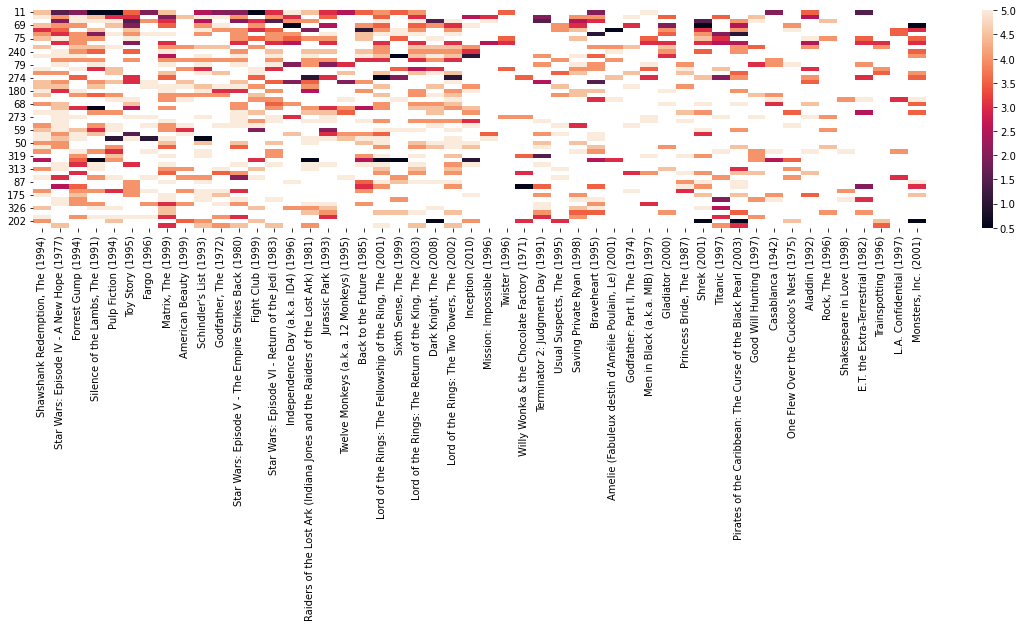

In [23]:
cluster_number = 6
n_users = 50
n_movies = 50

#Filtering the dataframe to extract user in cluster 6
cluster_6_predictions = results[results.group == cluster_number].drop(['group'], axis=1)

#Finding top 100 movies with most number of interactions
cluster_6_movies = find_most_rated_movies(cluster_6_predictions, n_movies)

#Finding top 100 users with most number of interactions 
cluster_6_users = find_most_interacted_users(cluster_6_movies, n_users)

#PLotting heatmap
figure = plt.figure(figsize=(20, 4))
sns.heatmap(cluster_6_users);

- The heatmap shows that cluster 6 is **dense with some NaN values**. 
- The majority of movies have been **rated 3 or above** by user in cluster 6

### Prediction

Now, as an example, let's **recommend movies** to a user from cluster 6. Let's select the user in cluster 6 with most number of interactions.

In [24]:
find_most_interacted_users(cluster_6_predictions, 1).index

Int64Index([619], dtype='int64')

- In cluster 6, the user with user ID 619 has rated the most number of movies.

In [25]:
cluster_6_predictions.loc[619, :]

Forrest Gump (1994)                            NaN
Pulp Fiction (1994)                            4.0
Shawshank Redemption, The (1994)               NaN
Silence of the Lambs, The (1991)               NaN
Star Wars: Episode IV - A New Hope (1977)      4.0
                                             ...  
Star Trek V: The Final Frontier (1989)         NaN
Island of Dr. Moreau, The (1996)               NaN
It Could Happen to You (1994)                  NaN
Ocean's Thirteen (2007)                        NaN
counts                                       101.0
Name: 619, Length: 1001, dtype: float64

In [26]:
user_id = 619

#Finding all the movies for user 619
user_id_ratings  = cluster_6_predictions.loc[user_id, :]

#Finding unrated movies for user 619
user_id_unrated_movies =  user_id_ratings[user_id_ratings.isnull()]

#Finding the average rating by users in cluster 6 for those unrated movies 
avg_ratings = pd.concat([user_id_unrated_movies, cluster_6_predictions.mean()], axis=1, join='inner').loc[:,0]

#Recommending top 20 movies
avg_ratings.sort_values(ascending=False)[:20]

Training Day (2001)                             5.000000
Ran (1985)                                      5.000000
Knight's Tale, A (2001)                         5.000000
Short Cuts (1993)                               5.000000
Lord of War (2005)                              5.000000
Old School (2003)                               5.000000
Black Hawk Down (2001)                          5.000000
Being There (1979)                              5.000000
Roger & Me (1989)                               4.833333
Lock, Stock & Two Smoking Barrels (1998)        4.833333
Old Boy (2003)                                  4.800000
Hackers (1995)                                  4.750000
Remains of the Day, The (1993)                  4.750000
Equilibrium (2002)                              4.750000
Raging Bull (1980)                              4.714286
Hitchhiker's Guide to the Galaxy, The (2005)    4.666667
Kramer vs. Kramer (1979)                        4.666667
Serpico (1973)                 

- These are the 20 movies with the highest average rating by users in cluster 6 but have not been rated/watched by user 619.

### Content Based Recommendation System

In content-based recommendation system, we would be using the feature - **text** i.e. reviews to find out similar movies

Text data generally contains pronunciation, stopwords, non-ASCII characters which makes it **very noisy**. So, we will first need to **pre-process the text** and then we will **generate features from the text to compute similarities** between the texts/reviews.

Let's load the **tags dataset**

In [27]:
tags = pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In this dataset, we don't have any movie review or plot of the movie, so we will combine the columns - **title**, **genres** from other two datasets and **tag** from tags dataset to create a text-based feature and apply **tfidf** feature extraction technique to extract features, which we later use to compute similar movies based on these texts.

In [28]:
#Merging all the three datasets on movieId
ratings_with_title = pd.merge(ratings, movies[['movieId', 'title', 'genres']], on='movieId' )
final_ratings = pd.merge(ratings_with_title, tags[['movieId', 'tag']], on='movieId' )
final_ratings

,userId,movieId,rating,timestamp,title,genres,tag
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,high school
1,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,teacher
2,7,31,3.0,851868750,Dangerous Minds (1995),Drama,high school
3,7,31,3.0,851868750,Dangerous Minds (1995),Drama,teacher
4,31,31,4.0,1273541953,Dangerous Minds (1995),Drama,high school
...,...,...,...,...,...,...,...
231860,624,135536,3.0,1470416022,Suicide Squad (2016),Action|Crime|Sci-Fi,poorly paced
231861,624,135536,3.0,1470416022,Suicide Squad (2016),Action|Crime|Sci-Fi,superhero
231862,624,135536,3.0,1470416022,Suicide Squad (2016),Action|Crime|Sci-Fi,visually appealing
231863,624,135536,3.0,1470416022,Suicide Squad (2016),Action|Crime|Sci-Fi,Will Smith


- There are **2,31,865 observations** and **7 columns** in the merged data
- We can see that **multiple genres are separated by | which we need to remove**.
- We will combine the three columns title, genres, and tag

In [29]:
#Replacing | character with space in genres column
final_ratings['genres'] = final_ratings['genres'].apply(lambda x: " ".join(x.split('|')))

In [30]:
#Combining title, genres, and tag columns
final_ratings['text'] = final_ratings['title'] + ' ' + final_ratings['genres'] + ' ' + final_ratings['tag']
final_ratings.head()

,userId,movieId,rating,timestamp,title,genres,tag,text
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,high school,Dangerous Minds (1995) Drama high school
1,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,teacher,Dangerous Minds (1995) Drama teacher
2,7,31,3.0,851868750,Dangerous Minds (1995),Drama,high school,Dangerous Minds (1995) Drama high school
3,7,31,3.0,851868750,Dangerous Minds (1995),Drama,teacher,Dangerous Minds (1995) Drama teacher
4,31,31,4.0,1273541953,Dangerous Minds (1995),Drama,high school,Dangerous Minds (1995) Drama high school


Now, we will **keep only four columns** - userId, movieId, rating, and text. We will drop the duplicate titles from the data and make it the **title column as the index** of the dataframe

In [31]:
final_ratings = final_ratings[['userId', 'movieId', 'rating', 'title', 'text']]
final_ratings = final_ratings.drop_duplicates(subset=['title'])
final_ratings = final_ratings.set_index('title')
final_ratings.head()

,userId,movieId,rating,text
title,,,,
Dangerous Minds (1995),1,31,2.5,Dangerous Minds (1995) Drama high school
Dumbo (1941),1,1029,3.0,Dumbo (1941) Animation Children Drama Musical ...
"Deer Hunter, The (1978)",1,1263,2.0,"Deer Hunter, The (1978) Drama War Vietnam"
Gandhi (1982),1,1293,2.0,Gandhi (1982) Drama India
Cape Fear (1991),1,1343,2.0,Cape Fear (1991) Thriller horror


In [33]:
final_ratings.shape

(1459, 4)

- The final shape of the data is (1459,4)

Now, let's process the text data and create features to find the similarity of movies

#### Loading libraries to handle text data

In [34]:
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'nltk'

In [35]:
!pip install nltk

We will create a **function to pre-process the text data**. Before that, let's see some **terminology**:
- **stopwords:** A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that does not contain information in the text and can be ignored.
- **Lemmatization:** Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.

In [ ]:
def tokenize(text):
    
    #Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    
    #Extracting each word in the text
    tokens = word_tokenize(text)
    
    #Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]
    
    #Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

### Feature Extraction

Below are some of the ways to extract features from texts - 
- Bag of words
- TF-IDF
- One hot encoding
- Word vectors

![alt text](tfidf.png)

Here, we will be using **tfidf** as a feature extraction technique

In [ ]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
movie_tfidf = tfidf.fit_transform(final_ratings['text'].values).toarray()

In [ ]:
pd.DataFrame(movie_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have extracted **2642 features** from the text data. Now, we can find similarities between movies using these features. We will use cosine similarity to calculate the similarity.

In [ ]:
similar_movies = cosine_similarity(movie_tfidf, movie_tfidf)
similar_movies

array([[1.        , 0.01742915, 0.01556585, ..., 0.        , 0.        ,
        0.        ],
       [0.01742915, 1.        , 0.01670343, ..., 0.        , 0.        ,
        0.        ],
       [0.01556585, 0.01670343, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.17872743,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17872743, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Finally, let's create a function to find most similar movies to recommend for a given movie

In [ ]:
# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(title, similar_movies):
    
    recommended_movies = []
    
    indices = pd.Series(final_ratings.index)
    
    # getting the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_movies[idx]).sort_values(ascending = False)

    # getting the indices of 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(final_ratings.index)[i])
        
    return recommended_movies

In [ ]:
recommendations('Usual Suspects, The (1995)', similar_movies)

[277, 1269, 332, 716, 397, 470, 485, 616, 331, 575]


['Game, The (1997)',
 'Andalusian Dog, An (Chien andalou, Un) (1929)',
 'Town, The (2010)',
 'Now You See Me (2013)',
 'Charade (1963)',
 'Negotiator, The (1998)',
 'Following (1998)',
 '21 Grams (2003)',
 'Inception (2010)',
 'Insomnia (2002)']

- The movie is a Crime , Mystery, Thriller movie and the majority of our recommendations lie in one or more of these genres which implies that the resulting recommendation system is working well.

### Conclusion

In this notebook, we have seen below recommendation techniques: 
- clustering based recommendation systems
- content based recommendation systems

We have see how they are different from each other and what kind of data is needed to build each of these two recommendation systems. We can further combine all the recommendation techniques we have seen so far to create a hybrid recommendation system.